<a href="https://colab.research.google.com/github/gifale95/NED/blob/main/tutorials/ned_fmri_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Encoding Dataset | In silico fMRI Data Tutorial

In this tutorial you will familiarize with the [Neural Encoding Dataset (NED)][ned]: trained encoding models of fMRI and EEG responses to images of multiple subjects. Through the [`NED` toolbox][github], you will use these trained encoding models to generate fMRI responses to images.

The Neural Encoding Dataset also comes with pre-generated in silico fMRI and EEG responses for ~150,000 naturalistic images from the [ImageNet 2012 Challenge][imagenet] ([*Russakovsky et al., 2015*][russakovsky]), the [THINGS Database][things] ([*Hebart et al., 2019*][hebart]), and the [Natural Scenes Dataset][nsd] ([*Allen et al., 2022*][allen]), which you can use for research purposes. Here you will load and visualize these in silico fMRI responses.

For more information on NED refer to the [data manual][data_manual]. The code used to create NED, along with its utility functions, is available on [GitHub][github].

You can run this tutorial either on [Colab][colab], or on [Jupyter Notebook][jupyter]. If you experience problems with the code, please get in touch with Ale (alessandro.gifford@gmail.com).

If you use the code and/or data from this tutorial, please cite:

> *Gifford AT, Cichy RM. 2024. The Neural Encoding Dataset. In preparation. https://github.com/gifale95/NED*

[ned]: https://www.alegifford.com/projects/ned/
[nsd]: https://naturalscenesdataset.org/
[allen]: https://doi.org/10.1038/s41593-021-00962-x
[imagenet]: https://www.image-net.org/challenges/LSVRC/2012/index.php
[russakovsky]: https://doi.org/10.1007/s11263-015-0816-y
[things]: https://things-initiative.org/
[hebart]: https://doi.org/10.1371/journal.pone.0223792
[data_manual]: https://docs.google.com/document/d/1DeQwjq96pTkPEnqv7V6q9g_NTHCjc6aYr6y3wPlwgDE/edit?usp=drive_link
[github]: https://github.com/gifale95/NED
[colab]: https://colab.research.google.com/drive/1W9Sroz2Y0eTYfyhVrAJwe50GGHHAGBdE?usp=sharing
[jupyter]: https://github.com/gifale95/NED/blob/main/tutorials/ned_fmri_tutorial.ipynb

# 0 | Configuration

Note that in sections `0.1 Install and import the necessary Python libraries` and `0.2 Access NED` you will have to run different code cells based on whether you are running the tutorial on Colab or on Jupyter Notebook. An `if statement` will take care of this. You only need to select `'colab'` or `'jupyter_notebook'` for the `platform` variable below.

In [ ]:
platform = "colab" # @param ["colab", "jupyter_notebook"] {allow-input: true}

## 0.1 | Install and import the necessary Python libraries

### 0.1.1 | Install libraries, Google Colab

If you are running the tutorial on Google Colab, you just need to install the [NED toolbox][ned_git].

[ned_git]: https://github.com/gifale95/NED

In [ ]:
!pip install -U git+https://github.com/gifale95/NED.git

  Cloning https://github.com/gifale95/NED.git to /tmp/pip-req-build-l1xqrh5o
  Running command git clone --filter=blob:none --quiet https://github.com/gifale95/NED.git /tmp/pip-req-build-l1xqrh5o
  Resolved https://github.com/gifale95/NED.git to commit 8d3e8e3d02f48e3c37c192486de6b3acce02ff3d
  Preparing metadata (setup.py) ... done


### 0.1.2 | Install libraries, Jupyter Notebook

If you are running the tutorial on Jupyter Notebook, you need to install the following libraries before running the tutorial:

[h5py][h5py], [jupyter][jupyter], [matplotlib][matplotlib], [ned][ned_git], [nibabel][nibabel], [numpy][numpy], [pillow][pil], [torchvision][torchvision], [tqdm][tqdm].

[h5py]: https://docs.h5py.org/en/stable/
[jupyter]: https://jupyter.org/
[matplotlib]: https://matplotlib.org/stable/index.html
[ned_git]: https://github.com/gifale95/NED
[nibabel]: https://nipy.org/nibabel/
[numpy]: https://numpy.org/
[pil]: https://pypi.org/project/pillow/
[torchvision]: https://pytorch.org/vision/stable/index.html
[tqdm]: https://tqdm.github.io/

### 0.1.3 | Import the libraries

Once you have installed all necessary libraries, import them with the following code.

In [ ]:
import h5py
import matplotlib
from matplotlib import pyplot as plt
from ned.ned import NED
import nibabel as nib
import numpy as np
import os
from PIL import Image
import torchvision
from torchvision import transforms as trn
from tqdm import tqdm

## 0.2 | Access NED

### 0.2.1 | Access NED on Google Colab

If you are running the tutorial on Google Colab you can use NED from the Google Drive public folder called [`neural_encoding_dataset`][ned]. Before running the tutorial code you need to right-click on this folder, and select `Organise` → `Add shortcut`. This will create a shortcut (without copying or taking space) of the folder to a desired path in your Google Drive, from which you can read the content after mounting using `drive.mount()`. Finally, edit the `ned_dir` variable below with the path on your Drive to the `neural_encoding_dataset` shortcut folder.

<font color='red'><b>NOTE:</b></font> **You need to manually create the data shortcut yourself, as the code cell below won't do this for you.**

[ned]: https://forms.gle/ZKxEcjBmdYL6zdrg9

In [ ]:
if platform == 'colab':
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)
    ned_dir = '/content/drive/MyDrive/neural_encoding_dataset' #@param {type:"string"}

Mounted at /content/drive/


### 0.2.2 | Access NED on Jupyter Notebook

If you are running the tutorial on Jupyter Notebook you first need to download NED from the public Google Drive folder [`neural_encoding_dataset`][data], and then edit the `ned_dir` variable below with the path to the downloaded and unzipped data folder.

Note that the `neural_encoding_dataset` folder contains several hundred GBs of data, and thus the download might take a while. However, based on your needs you might only choose to download a part of the dataset. [NED's data manual][ned_manual] provides a detailed description of NED's content, which will help you in this choice.

We recommend downloading the dataset directly from Google Drive via terminal using [Rclone][rclone]. [Here][guide] is a step-by-step guide for how to install and use Rclone to move files to and from your Google Drive. Before downloading NED via terminal you need to add a shortcut of the `neural_encoding_dataset` folder to your Google Drive. You can do this by right-clicking on the `neural_encoding_dataset` folder, and selecting `Organise` → `Add shortcut`. This will create a shortcut (without copying or taking space) of the folder to a desired path in your Google Drive, from which you can download its content.

[data]: https://forms.gle/ZKxEcjBmdYL6zdrg9
[ned_manual]: https://docs.google.com/document/d/1DeQwjq96pTkPEnqv7V6q9g_NTHCjc6aYr6y3wPlwgDE/edit#heading=h.n2idexbb49xj
[rclone]: https://rclone.org/
[guide]: https://noisyneuron.github.io/nyu-hpc/transfer.html

In [ ]:
if platform == 'jupyter_notebook':
    ned_dir = '../neural_encoding_dataset'

# 1 | Initialize NED

## 1.1 | Create the NED object

To use the `NED` toolbox, you first need to create a NED object, using the directory to the Neural Encoding Dataset.

In [ ]:
ned_object = NED(ned_dir)

## 1.2 | Browse the available encoding models

The Neural Encoding Dataset contains several encoding models of neural responses, which are taxonomized based on _attributes_:
* **modality:** the neural data modality on which the encoding model was trained.
* **train_dataset:** the neural dataset on which the encoding model was trained.
* **model:** the type of encoding model used.
* **subject:** independent subjects on which encoding models were trained (a separate encoding model is trained for each subject).
* **roi:** independent Regions of Interest (ROIs) on which encoding models were trained (a separate encoding model is trained for each ROI). This only applies to fMRI neural data modality.

Here you will print what fMRI encoding models are available for each attribute. For more information on the different models, see [NED's data manual][data_manual].

[data_manual]: https://docs.google.com/document/d/1DeQwjq96pTkPEnqv7V6q9g_NTHCjc6aYr6y3wPlwgDE/edit?usp=drive_link

### 1.2.1 | Neural acquisition modalities

Print the neural data modalities for which there are encoding models in NED.

In [ ]:
"""
Return the neural data modalities available in NED.

Returns
-------
modalities : list of str
    List of neural data modalities available in NED.
"""

modalities = ned_object.which_modalities()
print('Available neural data acquisition modalities:')
print(modalities)

Available neural data acquisition modalities:
['fmri', 'eeg']


### 1.2.2 | Neural datasets

For a given neural data modality, print the available neural datasets on which NED's encoding models were trained.

In [ ]:
"""
For a given neural data modality, return the available datasets on which
the NED encoding models are trained.

Parameters
-------
modality : str
    Neural data modality.

Returns
-------
train_datasets : list of str
    List of neural datasets on which the NED encoding models are
    trained.
"""

modality = "fmri" # @param ["fmri"] {allow-input: true}
train_datasets = ned_object.which_train_datasets(modality)
print('Available datasets:')
print(train_datasets)

Available datasets:
['nsd']


### 1.2.3 | Encoding model types

For a given neural data modality and training dataset, print the encoding model types available in NED.

In [ ]:
"""
For a given neural data modality and training dataset, return the
encoding model types available in NED.

Parameters
-------
modality : str
    Neural data modality.
train_dataset : str
    Neural dataset on which the NED encoding models are trained.

Returns
-------
models : list of str
    List of NED encoding models trained on a given neural data modality
    and neural dataset.
"""

modality = "fmri" # @param ["fmri"] {allow-input: true}
train_dataset = "nsd" # @param ["nsd"] {allow-input: true}
models = ned_object.which_models(modality, train_dataset)
print('Available models:')
print(models)

Available models:
['fwrf']


### 1.2.4 | Subjects

For a given neural data modality and training dataset, print the subjects for which there are trained encoding models.

In [ ]:
"""
For a given neural data modality and training dataset, return the
available subjects on which encoding models are trained.

Parameters
-------
modality : str
    Neural data modality.
train_dataset : str
    Neural dataset on which the NED encoding models are trained.

Returns
-------
subjects : list of int
    List of available subjects for a given data modality and training
    dataset.
"""

modality = "fmri" # @param ["fmri"] {allow-input: true}
train_dataset = "nsd" # @param ["nsd"] {allow-input: true}
subjects = ned_object.which_subjects(modality, train_dataset)
print('Available subjects:')
print(subjects)

Available subjects:
[1, 2, 3, 4, 5, 6, 7, 8]


### 1.2.5 | ROIs

For a given fMRI training dataset, print the available ROIs for which there are trained encoding models.

In [ ]:
"""
For a given fMRI training dataset, return the available ROIs on which
encoding models are trained.

Parameters
-------
train_dataset : str
    Neural dataset on which the NED encoding models are trained.

Returns
-------
rois : list of str
    List of available rois for a given fMRI training dataset.
"""

train_dataset = "nsd" # @param ["nsd"] {allow-input: true}
rois = ned_object.which_rois(train_dataset)
print('Available ROIs:')
print(rois)

Available ROIs:
['V1', 'V2', 'V3', 'hV4', 'EBA', 'FBA-2', 'OFA', 'FFA-1', 'FFA-2', 'PPA', 'RSC', 'OPA', 'OWFA', 'VWFA-1', 'VWFA-2', 'mfs-words', 'early', 'midventral', 'midlateral', 'midparietal', 'parietal', 'lateral', 'ventral']


# 2 | Generate in silico fMRI responses to images

Now you will use the trained encoding models from NED to generate in silico fMRI responses to images.

## 2.1 | Load and prepare the images for which the in silico fMRI responses are generated

First, you will list the 100 images for which you will generate the in silico fMRI responses.

In [ ]:
images_dir = os.path.join(ned_dir, 'ned_tutorials', 'tutorial_images')
images_list = os.listdir(images_dir)
images_list.sort()
print('Images:')
for i, img in enumerate(images_list):
    print(str(i+1) + ': ' + img)

Images:
1: 000000000139.jpg
2: 000000000285.jpg
3: 000000000632.jpg
4: 000000000724.jpg
5: 000000000776.jpg
6: 000000000785.jpg
7: 000000000802.jpg
8: 000000000872.jpg
9: 000000000885.jpg
10: 000000001000.jpg
11: 000000001268.jpg
12: 000000001296.jpg
13: 000000001353.jpg
14: 000000001425.jpg
15: 000000001490.jpg
16: 000000001503.jpg
17: 000000001532.jpg
18: 000000001584.jpg
19: 000000001675.jpg
20: 000000001761.jpg
21: 000000001818.jpg
22: 000000001993.jpg
23: 000000002006.jpg
24: 000000002149.jpg
25: 000000002153.jpg
26: 000000002157.jpg
27: 000000002261.jpg
28: 000000002299.jpg
29: 000000002431.jpg
30: 000000002473.jpg
31: 000000002532.jpg
32: 000000002587.jpg
33: 000000002592.jpg
34: 000000002685.jpg
35: 000000002923.jpg
36: 000000003156.jpg
37: 000000003255.jpg
38: 000000003501.jpg
39: 000000003553.jpg
40: 000000003661.jpg
41: 000000003845.jpg
42: 000000003934.jpg
43: 000000004134.jpg
44: 000000004395.jpg
45: 000000004495.jpg
46: 000000004765.jpg
47: 000000004795.jpg
48: 0000000050

Now you will load these images. NED's encoding models require the images to be a 4-D numpy array of shape (Batch size x 3 RGB Channels x Width x Height) consisting of integer values in the range [0, 255]. Furthermore, the images must be of square size (i.e., equal width and height), therefore you will center crop them to square format during loading.

In [ ]:
images = []
for img in tqdm(images_list):
    img_dir = os.path.join(images_dir, img)
    img = Image.open(img_dir).convert('RGB')
    # Center crop the images to square format, and resize them
    transform = trn.Compose([
        trn.CenterCrop(min(img.size)),
        trn.Resize((227,227))
    ])
    img = transform(img)
    img = np.asarray(img)
    img = img.transpose(2,0,1)
    images.append(img)
images = np.asarray(images)

# Print the images dimensions
print('\n\nImages shape:')
print(images.shape)
print('(Batch size × 3 RGB Channels x Width x Height)')

100%|██████████| 100/100 [00:03<00:00, 30.52it/s]



Images shape:
(100, 3, 227, 227)
(Batch size × 3 RGB Channels x Width x Height)


Finally, here you can visualize the images you just loaded.

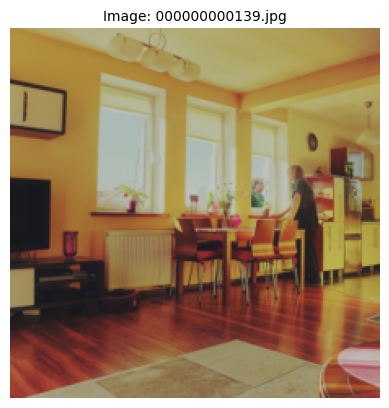

In [ ]:
# Choose the image you would like to visualize
img_num = 0 # @param {type:"slider", min:0, max:99, step:1}

# Plot the image
plt.figure()
plt.axis('off')
plt.imshow(images[img_num].transpose(1,2,0))
plt.title('Image: ' + images_list[img_num], fontsize=10);

## 2.2 | Generate in silico fMRI responses to images

Generating neural responses for images involves two steps. First, you need to choose the training dataset, encoding model type, subject and ROI, and load the corresponding fMRI encoding model using the `get_encoding_model` method.

We provide fMRI encoding models for the following (NSD) ROIs:
* **Early retinotopic visual regions:** V1, V2, V3, hV4.
* **Body-selective regions:** EBA, FBA-2.
* **Face-selective regions:** OFA, FFA-1, FFA-2.
* **Place-selective regions:** OPA, PPA, RSC.
* **Word-selective regions:** OWFA, VWFA-1, VWFA-2, mfs-words.
* **Anatomical streams:** early, midventral, midlateral, midparietal, ventral, lateral, parietal.

For more information on the NSD ROIs, please see the [NSD data manual][nsd_man].

If you select encoding models trained on NSD, note that the fMRI data used to train and evaluate these encoding models were _z_-scored at each scan session. As a consequence, their generated in silico fMRI responses also live in _z_-scored space.

<font color='red'><b>NOTE:</b></font> **The in silico fMRI generation will be faster using if GPU is available.**

[nsd_man]: https://cvnlab.slite.page/p/X_7BBMgghj/ROIs

In [ ]:
# Choose the neural dataset used to train the encoding models
train_dataset = "nsd" # @param ["nsd"] {allow-input: true}
print('Train dataset: ' + train_dataset)

# Choose the encoding model type used to generate the in silico neural responses
model = "fwrf" # @param ["fwrf"] {allow-input: true}
print('Encoding model: ' + model)

# Choose the Subject number for which the encoding model was trained
subject = 1 # @param ["1", "2", "3", "4", "5", "6", "7", "8"] {type:"raw", allow-input: true}
print('Subject: ' + str(subject))

# Choose the Region of Interest (ROI) for which the fMRI encoding model was
# trained
roi = "V1" # @param ["V1", "V2", "V3", "hV4", "EBA", "FBA-2", "OFA", "FFA-1", "FFA-2", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}
print('ROI: ' + roi)

Train dataset: nsd
Encoding model: fwrf
Subject: 1
ROI: V1


In [ ]:
"""
Load the encoding model of interest.

Parameters
----------
modality : str
	Neural data modality.
train_dataset : str
	Name of the neural dataset used to train the encoding models.
model : str
	Encoding model type used to generate the in silico neural
	responses.
subject : int
	Subject number for which the encoding model was trained.
roi : str
	Only required if modality=='fmri'. Name of the Region of Interest
	(ROI) for which the fMRI encoding model was trained.
device : str
	Whether the encoding model is stored on the 'cpu' or 'cuda'. If
	'auto', the code will use GPU if available, and otherwise CPU.

Returns
-------
encoding_model : dict
	Neural encoding model.
"""

# Load the fMRI encoding model
fmri_encoding_model = ned_object.get_encoding_model(
	modality='fmri',
	train_dataset=train_dataset,
	model=model,
	subject=subject,
	roi=roi,
	device='auto'
	)

/usr/local/lib/python3.10/dist-packages/ned/utils.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model = torch.load(model_dir,


Next, with the `encode` method you can generate in silico fMRI responses to any image of your choice, and optionally return the corresponding metadata.

In [ ]:
"""
Generate in silico neural responses for arbitrary stimulus images, and
optionally return the in silico neural responses metadata.

Parameters
----------
encoding_model : list
	Neural encoding model.
images : int
	Images for which the in silico neural responses are generated. Must
	be a 4-D numpy array of shape (Batch size x 3 RGB Channels x Width
	x Height) consisting of integer values in the range [0, 255].
	Furthermore, the images must be of square size (i.e., equal width
	and height).
return_metadata : bool
	If True, return medatata along with the in silico neural responses.
device : str
	Whether to work on the 'cpu' or 'cuda'. If 'auto', the code will
	use GPU if available, and otherwise CPU.

Returns
-------
insilico_neural_responses : float
	In silico neural responses for the input stimulus images.
	If modality=='fmri', the neural response will be of shape:
	(Images x Voxels).
	If modality=='eeg', the neural response will be of shape:
	(Images x Repetitions x Channels x Time points) if
metadata : dict
	In silico neural responses metadata.
"""

# Encode fMRI responses to images
insilico_fmri, insilico_fmri_metadata = ned_object.encode(
	fmri_encoding_model,
	images,
	return_metadata=True,
	device='auto'
	)

Encoding fMRI responses: 100%|██████████| 1/1 [00:11<00:00, 11.19s/it, Encoded images=100, Total images=100]


The generated in silico fMRI responses consist of a 2-D array of shape (Images × Voxels).

In [ ]:
# Print the in silico fMRI data dimensions
print('In silico fMRI data shape:')
print(insilico_fmri.shape)
print('(Images × Voxels)')

In silico fMRI data shape:
(100, 1350)
(Images × Voxels)


# 3 | In silico fMRI responses metadata

The in silico fMRI responses optionally come with useful metadata. Note that you can also load the metadata using the `get_metadata` method, without having to generate the in silico fMRI responses using the `encode` method.

In [ ]:
"""
Get the metadata, consisting in information on the neural data used to
train the encoding models (e.g., the amount of fMRI voxels or EEG time
points), and on the trained encoding models (e.g., how was the data
split to train and test the models, and the models accuracy scores).

Parameters
----------
modality : str
    Neural data modality.
train_dataset : str
    Name of the neural dataset used to train the encoding models.
model : str
    Encoding model type used to generate the in silico neural
    responses.
subject : int
    Subject number for which the metadata is loaded.
roi : str
    Only required if modality=='fmri'. Name of the Region of Interest
    (ROI) for which the metadata is loaded.

Returns
-------
metadata : dict
    In silico neural responses metadata.
"""

# Get the metadata relative to the in silico fMRI responses
insilico_fmri_metadata = ned_object.get_metadata(
	modality='fmri',
	train_dataset=train_dataset,
	model=model,
	subject=subject,
	roi=roi
	)

The metadata consists of a dictionary with two keys:
* `fmri`: metadata relative to the fMRI responses used to train the encoding models.
* `encoding_models`: metadata relative to the trained fMRI encoding models.

## 3.1 | fMRI metadata

Here you will familiarize with the metadata from the `fmri` key, that is, metadata relative to the fMRI responses used to train the encoding models.

### 3.1.1 | Noise ceiling signal-to-noise ratio (ncsnr)

The noise ceiling signal-to-noise ratio (`ncsnr`) variable is a 1-D vector of length (Voxels), where each vector component indicates the signal-to-noise ratio score for a given voxel.

This value reflects the ratio between the signal and noise standard deviations of a given voxel, and can be used for example to select voxels with high signal-to-noise ratio, or discard voxels with low signal-to-noise ratio.

These ncsnr scores come unaltered from the Natural Scenes Dataset (NSD). For detailed information on how these scores were computed, see the [NSD paper][allen].

[allen]: https://doi.org/10.1038/s41593-021-00962-x

In [ ]:
# Print the ncsnr shape
print('Noise ceiling signal-to-noise ratio (ncsnr) shape:')
print(insilico_fmri_metadata['fmri']['ncsnr'].shape)
print('(Voxels)')

Noise ceiling signal-to-noise ratio (ncsnr) shape:
(1350,)
(Voxels)


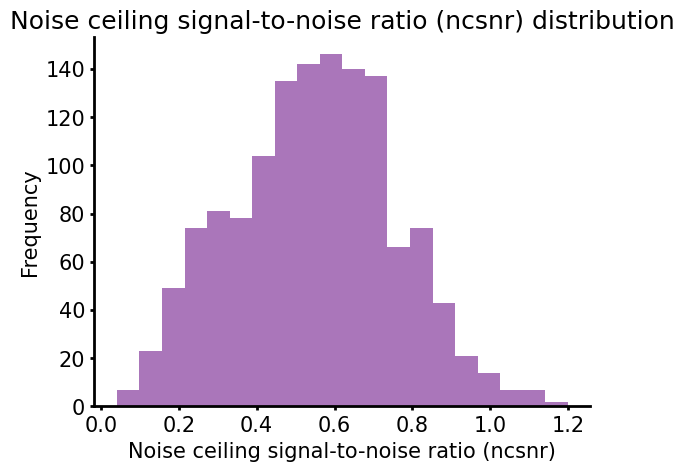

In [ ]:
# Plot parameters
fontsize = 15
matplotlib.rcParams['font.sans-serif'] = 'DejaVu Sans'
matplotlib.rcParams['font.size'] = fontsize
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['xtick.major.size'] = 3
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['ytick.major.size'] = 3
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.bottom'] = True
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['lines.markersize'] = 3
colors = [(170/255, 118/255, 186/255)]

# Plot the ncsnr distribution using a histogram
plt.hist(insilico_fmri_metadata['fmri']['ncsnr'], bins=20, color=colors[0])
plt.title('Noise ceiling signal-to-noise ratio (ncsnr) distribution')
plt.xlabel('Noise ceiling signal-to-noise ratio (ncsnr)')
plt.ylabel('Frequency')
plt.show()

### 3.1.2 | Reshape the in silico fMRI responses to subject-native volume space

You can use the `roi_mask_volume` and `fmri_affine` variables to map the voxel responses of the selected subject and ROI back to 3-D subject-native volume space, and from there to a nifti image.

`roi_mask_volume` is a 3-D boolean matrix covering the entire fMRI acquisition volume space, with _True_ values indicating the voxels of the ROI of interest.

`fmri_affine` is the 4×4 fMRI volume transformation matrix.

In [ ]:
# Reshape the in silico fMRI response back to subject-native volume space
sub_native_vol_space = []
# Loop over images
for fmri in insilico_fmri:
    vol_space = np.zeros(
        insilico_fmri_metadata['fmri']['roi_mask_volume'].shape)
    vol_space[insilico_fmri_metadata['fmri']['roi_mask_volume']] = fmri
    sub_native_vol_space.append(vol_space)
sub_native_vol_space = np.asarray(sub_native_vol_space)

print('Subject-native volume space shape:')
print(sub_native_vol_space.shape)
print('(Images × Voxels × Voxels × Voxels)')

# Convert the data into a nifti image
sub_native_vol_space_nii = nib.Nifti1Image(sub_native_vol_space,
    insilico_fmri_metadata['fmri']['fmri_affine'])

# You can then save the new nifti image using the following function:
# >>> nib.save(sub_native_vol_space_nii, 'sub_native_vol_space_nii.nii')

Subject-native volume space shape:
(100, 81, 104, 83)
(Images × Voxels × Voxels × Voxels)


## 3.2 | Encoding models metadata

Now you will familiarize with the metadata from the `encoding_models` key, that is, metadata relative to the trained fMRI encoding models.

### 3.2.1 | Encoding models encoding accuracy

First, you will plot the encoding accuracy of the encoding models for the selected subject and ROI.

For each NSD subject and ROI, one encoding models was trained using the (up to) 9000 non-shared images (i.e., the images uniquely seen by each subject during the NSD experiment), and tested them on 515 (out of 1000) shared images (i.e., the 515 images that each subject saw for exactly three times during the NSD experiment). We used the trained encoding models to generate in silico fMRI responses for the 515 test images, and compared these in silico responses to the ground truth (real) fMRI responses through a Pearson's correlation. We correlated ground-truth and in silico fMRI responses independently for each voxel (across the 515 test images), and squared the correlation scores resulting in one explained variance score (*r*²) for each voxel. Finally, we normalized the *r*² scores through division with the noise ceiling (i.e., the maximal explainable variance given the noise in the data), obtaining the noise-ceiling-normalized encoding accuracy for each voxel: this score indicates the percentage of explainable variance that has been accounted for by the encoding model.

You will first plot the noise-ceiling-normalized encoding accuracy (i.e., `explained_variance`) averaged across all voxels of the chosen ROI.

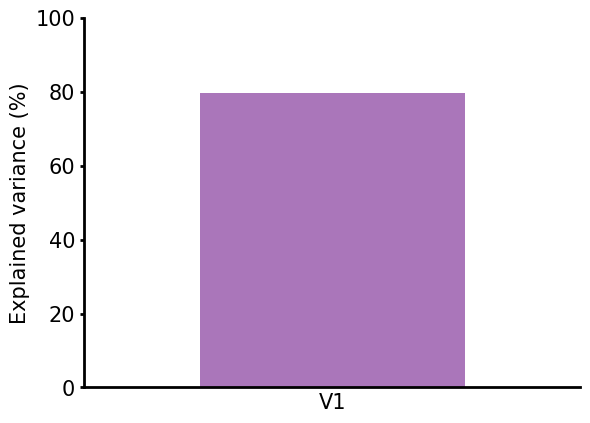

In [ ]:
# Plot parameters
fontsize = 15
matplotlib.rcParams['font.sans-serif'] = 'DejaVu Sans'
matplotlib.rcParams['font.size'] = fontsize
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['xtick.major.size'] = 3
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['ytick.major.size'] = 3
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.bottom'] = True
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['lines.markersize'] = 3
colors = [(170/255, 118/255, 186/255)]

# Plot the mean noise-ceiling normalized encoding accuracy
encoding_acc = np.mean(insilico_fmri_metadata['encoding_models']\
    ['encoding_accuracy']['noise_normalized_encoding']) * 100
plt.plot()
plt.bar(1, encoding_acc, color=colors[0])
plt.ylabel('Explained variance (%)',
    fontsize=fontsize)
plt.ylim(bottom=0, top=100)
plt.xlabel(roi, fontsize=fontsize)
plt.xticks([])
plt.xlim(left=0.25, right=1.75);

Next, you will plot the voxel-wise encoding accuracy scores (`r²` scores) against the corresponding `noise_ceiling` scores, on a scatterplot.

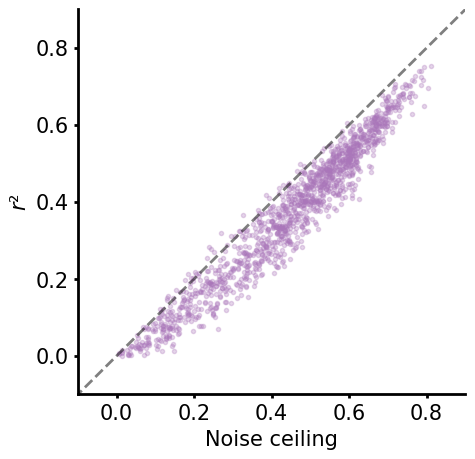

In [ ]:
r2 = insilico_fmri_metadata['encoding_models']['encoding_accuracy']['r2']
noise_ceiling = insilico_fmri_metadata['encoding_models']['encoding_accuracy']\
    ['noise_ceiling']

plt.figure(figsize=(5,5))
plt.plot(np.arange(-1,1.1,.1), np.arange(-1,1.1,.1), '--k', linewidth=2,
    alpha=.5)
plt.scatter(noise_ceiling, r2, color=colors[0], alpha=.3)
plt.ylabel('$r$²', fontsize=fontsize)
plt.ylim(bottom=-.1, top=.9)
plt.xlabel('Noise ceiling', fontsize=fontsize)
plt.xlim(left=-.1, right=.9);

### 3.2.2 | Encoding models train/val/test split

Finally, here you will plot the NSD image IDs used to train (`train_img_num`), validate (`val_img_num`), and test (`test_img_num`) the encoding model for the chosen subject and ROI (the image IDs are zero-based, meaning that image ID "0" corresponds to the first NSD image.).

In [ ]:
# Training image conditions
train_conditions = insilico_fmri_metadata\
    ['encoding_models']['train_val_test_nsd_image_splits']['train_img_num']
print('Training image condition number: ' + str(len(train_conditions)))
print('Training image conditions:')
print(train_conditions)

# Validation image conditions
val_conditions = insilico_fmri_metadata\
    ['encoding_models']['train_val_test_nsd_image_splits']['val_img_num']
print('\n\nValidation image condition number: ' + str(len(val_conditions)))
print('Validation image conditions:')
print(val_conditions)

# Test image conditions
test_conditions = insilico_fmri_metadata\
    ['encoding_models']['train_val_test_nsd_image_splits']['test_img_num']
print('\n\nTest image condition number: ' + str(len(test_conditions)))
print('Test image conditions:')
print(test_conditions)

Training image condition number: 9000
Training image conditions:
[ 2244 32051 19058 ... 19471 49507 11123]


Validation image condition number: 485
Validation image conditions:
[ 2950  2990  3146  3181  3386  3729  3951  4058  4129  4156  4325  4436
  4612  4768  4869  5106  5285  5427  5459  5502  5574  5714  5878  5890
  6132  6222  6514  6524  6558  6640  6713  7336  7409  7418  7480  7659
  7948  7954  8204  8262  8274  8318  8387  8415  8435  8465  8631  8843
  8925  9230  9462  9680  9722  9804  9847  9865  9978 10393 10507 10586
 10600 10610 10907 11487 11566 11827 12065 12075 12214 12487 12495 12634
 12685 12798 12937 13230 13653 13662 13720 13846 14110 14121 14165 14443
 14567 14644 14808 14931 15003 15025 15128 15492 15793 16063 16421 16466
 16635 16655 16723 16841 16865 16868 17230 17238 17369 17450 17463 17595
 17776 17794 17942 18268 18483 18505 18535 18690 18796 19200 19292 19573
 19642 19672 19690 20064 20223 20307 20702 20777 21197 21318 21508 21526
 21553 21703 21989 2

# 4 | Load and visualize the pre-generated in silico fMRI responses

The Neural Encoding Dataset comes with pre-generated in silico fMRI and EEG responses for ~150,000 naturalistic images from the [ImageNet 2012 Challenge][imagenet] ([*Russakovsky et al., 2015*][russakovsky]), the [THINGS Database][things] ([*Hebart et al., 2019*][hebart]), and the [Natural Scenes Dataset][nsd] ([*Allen et al., 2022*][allen]), which you can use for research purposes. Here you will load and visualize these in silico fMRI responses.

[nsd]: https://naturalscenesdataset.org/
[allen]: https://doi.org/10.1038/s41593-021-00962-x
[imagenet]: https://www.image-net.org/challenges/LSVRC/2012/index.php
[russakovsky]: https://doi.org/10.1007/s11263-015-0816-y
[things]: https://things-initiative.org/
[hebart]: https://doi.org/10.1371/journal.pone.0223792

## 4.1 | Data selection

We provide pre-generated in silico fMRI responses for the following attribute conmbinations:
* `train_dataset == 'nsd'`
* `model == 'fwrf'`

Here you can choose the subject, ROI and imageset for which you will load the pre-generated in silico fMRI responses.

Note that the NSD data used to train and evaluate the encoding models were _z_-scored at each scan session. As a consequence, the pre-generated in silico fMRI responses also live in _z_-scored space.

In [ ]:
# Used subject
subject = 1 # @param ["1", "2", "3", "4", "5", "6", "7", "8"] {type:"raw", allow-input: true}
print('Subject: ' + str(subject))

# Used ROI
roi = "V1" # @param ["V1", "V2", "V3", "hV4", "EBA", "FBA-2", "OFA", "FFA-1", "FFA-2", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}
print('ROI: ' + roi)

# Used image set
imageset = "nsd" # @param ["nsd", "imagenet_val", "things"] {allow-input: true}
print('Imageset: ' + imageset)

Subject: 1
ROI: V1
Imageset: nsd


## 4.2 | Load the in silico fMRI responses

Now you will load the in silico fMRI responses for the chosen subject, ROI and image set, using the `load_insilico_neural_responses` method.

The in silico fMRI responses consist of a 2-D array of shape (Images × Voxels).

In [ ]:
"""
Load NED's pre-generated in silico neural responses, and optionally
their metadata.

Parameters
----------
modality : str
	Neural data modality.
train_dataset : str
	Name of the neural dataset used to train the encoding models.
model : str
	Encoding model type used to generate the in silico neural
	responses.
imageset : str
	Imageset for which the in silico neural responses are generated.
	Available options are 'nsd', 'imagenet_val' and 'things'.
	If 'nsd', load in silico neural responses for the 73,000 NSD images
	(Allen et al., 2023).
	If 'imagenet_val', load in silico neural responses for the 50,000
	ILSVRC-2012 validation images (Russakovsky et al., 2015).
	If 'things', load in silico neural responses for the 26,107 images
	from the THINGS database (Hebart et al., 2019).
subject : int
	Subject number for which the in silico neural image responses are
	generated.
roi : str
	Only required if modality=='fmri'. Name of the Region of Interest
	(ROI) for which the in silico fMRI responses are generated.
return_metadata : bool
	If True, additionally return in silico neural responses metadata.

Returns
-------
insilico_neural_responses : h5py
	In silico neural responses for the input stimulus images.
	If modality=='fmri', the neural response will be of shape:
	(Images x Voxels).
	If modality=='eeg', the neural response will be of shape:
	(Images x Repetitions x Channels x Time points) if
metadata : dict
	In silico neural responses metadata.
"""

# Load the pre-generated in silico fMRI responses
insilico_fmri, insilico_fmri_metadata = ned_object.load_insilico_neural_responses(
	modality='fmri',
	train_dataset='nsd',
	model='fwrf',
	imageset=imageset,
	subject=subject,
	roi=roi,
	return_metadata=True
	)

# Print the in silico fMRI data dimensions
print('In silico fMRI data shape:')
print(insilico_fmri.shape)
print('(Images × Voxels)')

In silico fMRI data shape:
(73000, 1350)
(Images × Voxels)


The `load_insilico_neural_responses` method optionally returns metadata for the pre-generated in silico fMRI responses.

This metadata is identical to the metadata loaded with the `get_metadata` method in section `3 | In silico fMRI responses metadata`, with the addition of information relative to the image sets used to generate the in silico fMRI responses. You will use this additional image-set-related metadata in the next section.

## 4.3 | Link the in silico fMRI responses to the corresponding images

Here you will match the pre-generated in silico fMRI responses to the corresponding images. You will start by accessing the imagesets. Since the NSD, ILSVRC-2012, and THINGS imagesets are organized differently, you will access each of them in a different way.

<font color='red'><b>NOTE:</b></font> **Prior to using the NSD images you are required to fill out the [NSD Data Access Agreement][nsd_access].**

[nsd_access]: https://forms.gle/eT4jHxaWwYUDEf2i9

In [ ]:
# Access the imagesets
if imageset == 'nsd':
    imageset_dir = os.path.join(ned_dir,
        'pregenerated_insilico_neural_responses', 'imagesets', 'imageset-nsd',
        'nsd_stimuli.hdf5')
    images = h5py.File(imageset_dir, 'r')
    images = images.get('imgBrick')
elif imageset == 'imagenet_val':
    imageset_dir = os.path.join(ned_dir,
        'pregenerated_insilico_neural_responses', 'imagesets',
        'imageset-imagenet_val')
    images = torchvision.datasets.ImageNet(root=imageset_dir, split='val')
elif imageset == 'things':
    images = insilico_fmri_metadata['things_labels']['image_paths']

Here you can choose an image (indexing is zero-based), and link it to the corresponding in silico fMRI response.

In [ ]:
# Choose the image
if imageset == 'nsd':
    nsd_img = 0 # @param {type:"slider", min:0, max:72999, step:1}
    img_idx = nsd_img
elif imageset == 'imagenet_val':
    imagenet_img = 0 # @param {type:"slider", min:0, max:49999, step:1}
    img_idx = imagenet_img
elif imageset == 'things':
    things_img = 0 # @param {type:"slider", min:0, max:26106, step:1}
    img_idx = things_img

# Link the image to the corresponding in silico fMRI response
fmri_response = insilico_fmri[img_idx]
print('In silico fMRI response shape:')
print(fmri_response.shape)
print('(Voxels)')

In silico fMRI response shape:
(1350,)
(Voxels)


And now you will load and visualize the image you chose, along with optional metadata (e.g., image category).

Since the ILSVRC-2012 images are rectangular, we center cropped them to square format prior to feeding them to encoding models to generate their corresponding in silico fMRI responses. Here you will apply the same center cropping when loading these images. The NSD and THINGS images are already in square format, and therefore don't require any cropping.

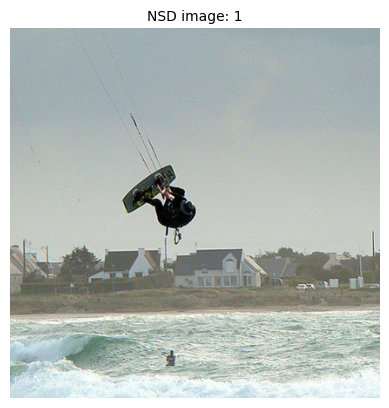

In [ ]:
# Load the selected image
if imageset == 'nsd':
    img = images[img_idx]
elif imageset == 'imagenet_val':
    img, _ = images.__getitem__(img_idx)
    transform = trn.Compose([trn.CenterCrop(min(img.size))])
    img = transform(img)
elif imageset == 'things':
    img_dir = os.path.join(ned_dir, 'pregenerated_insilico_neural_responses',
        'imagesets', 'imageset-things', 'images', images[img_idx])
    img = Image.open(img_dir).convert('RGB')

# Visualize the image (along with otptional metadata)
plt.figure()
plt.axis('off')
plt.imshow(img)
if imageset == 'nsd':
    title = 'NSD image: ' + str(img_idx+1)
elif imageset == 'imagenet_val':
    label_number = insilico_fmri_metadata['imagenet_val_labels']\
        ['label_number'][img_idx]
    label_name = \
        insilico_fmri_metadata['imagenet_val_labels']['label_names']\
            [label_number]
    title = 'ILSVRC-2012 validation image: ' + str(img_idx+1) + \
        '\nCategory number: ' + str(label_number+1) + \
        '\nCategory name: ' + label_name
elif imageset == 'things':
    object_concept_number = \
        insilico_fmri_metadata['things_labels']['image_concept_index'][img_idx]
    object_concept_name = \
        insilico_fmri_metadata['things_labels']['unique_id']\
            [object_concept_number]
    file_name = \
        insilico_fmri_metadata['things_labels']['image_paths'][img_idx]
    title = 'THINGS image: ' + str(img_idx+1) + \
        '\nObject concept number: ' + str(object_concept_number+1) + \
        '\nObject concept name: ' + object_concept_name + \
        '\nFile name: ' + file_name
plt.title(title, fontsize=10);